In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def runge_kutta(function, y0: np.ndarray | float, time_space: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    h = time_space[1] - time_space[0]
    num = len(time_space)
    x_a = time_space

    y_a = [y0] * (num)

    for i in range(num - 1):
        k0 = function(x_a[i], y_a[i])
        k1 = function(x_a[i] + h / 2, y_a[i] + h * k0 / 2)
        k2 = function(x_a[i] + h / 2, y_a[i] + h * k1 / 2)
        k3 = function(x_a[i] + h, y_a[i] + h * k2)
        y_a[i + 1] = y_a[i] + h / 6 * (k0 + 2 * k1 + 2 * k2 + k3)

    return x_a, np.array(y_a)

In [10]:
n = 4 # 0 - 3
q = 3
print(f"{q=}")

Q = 100
alpha = np.array([20, 16, 12, 8]) # n
k = np.append([0], [0.3, 0.2, 0.1]) # n-1, 0<=k_i<=1
m = np.append([0], [4, 3, 2]) # n-1
a = np.append([0], [0.9, 0.9, 0.9]) # n-1, 0<=a_i<=1

g = np.append([0], k[1:] * alpha[:-1] / alpha[1:])
H = np.append([1], [ np.prod(g[2-(i%2):i+2:2]) for i in range(1, n) ])

mu =np.append([0], m[1:] / alpha[1:])
f = np.append([0], [ sum(mu[2-(i%2):i+2:2]/H[2-(i%2):i+2:2]) for i in range(1, n) ])

print( alpha, k, m )

q=3
[20 16 12  8] [0.  0.3 0.2 0.1] [0 4 3 2]


In [11]:
# Flow

N = np.zeros(n)

if q % 2 == 0:
    N[0] = Q / ( alpha[0] * f[q] )
    N[1] = f[q]
else:
    N[0] = f[q]
    N[1] = Q / ( alpha[0] * f[q] )


for s in range(1, n//2):
    N[s*2] = H[2*s-1] * (N[0] - f[2*s-1])
    N[s*2+1] = H[2*s] * (N[1] - f[2*s])

NF = N.copy()
NF = np.where(NF < 0, 0, NF)

print( alpha[0] * f[:-1] * f[1:] )
print(NF)

[ 0.         12.5        95.83333333]
[5.11111111 0.97826087 1.66666667 0.01086957]


In [12]:
# Cycle

_phi = a[2::2] * m[2::2] * H[1::2]
phi = np.append([0], np.cumsum(_phi) )

_psi = a[1::2] * m[1::2] * H[::2]
psi = np.append([0], np.cumsum(_psi) )

_omega = a[1:] * m[1:] * f[:-1] * H[:-1]
omega = np.append([0], np.cumsum(_omega) )

N = np.zeros(n)

if q % 2 == 0:
    N[0] = ( Q + f[q] * psi[q//2] - omega[q] ) / ( alpha[0] * f[q] - phi[q//2] )
    N[1] = f[q]
else:
    N[0] = f[q]
    N[1] = ( Q + f[q] * psi[q//2] - omega[q] ) / ( alpha[0] * f[q] - phi[q//2 + 1] )


for s in range(1, n//2):
    N[s*2] = H[2*s-1] * (N[0] - f[2*s-1])
    N[s*2+1] = H[2*s] * (N[1] - f[2*s])


NC = N.copy()

print(NC)

[5.11111111 1.16047396 1.66666667 0.05945972]


In [13]:
# flow chain
def get_right_flow(func_v, func_1=None):
    func_1 = func_1 or func_v
    def right_flow(t, x):
        return np.append(
            [Q - alpha[0] * func_1(x[0]) * x[1]],
            [
                -m[i] * x[i] + k[i] * alpha[i-1] * func_v(x[i-1]) * x[i] - (x[i+1] if i < n-1 else 0 ) * alpha[i] * func_v(x[i])
                for i in range(1, n)
            ]
        )
    return right_flow

def identity(x):
    return x

# def right_flow(t, x):
#     return np.append(
#         [Q - alpha[0] * x[0] * x[1]],
#         [
#             x[i] * (-m[i] + k[i] * alpha[i-1] * x[i-1] - (alpha[i] * x[i+1] if i < n-1 else 0 ))
#             for i in range(1, n)
#         ]
#     )

In [14]:
t_s = np.arange(0, 100, 0.01)
N0 = np.array([ 2 ] * n)

right_flow = get_right_flow(identity)
# right_flow = get_right_flow(np.atan)

Tl, Nl = runge_kutta(right_flow, N0, t_s)

[5.11111111 0.97826087 1.66666667 0.01086957]
[5.11109922 0.97826313 1.66666222 0.01087015]


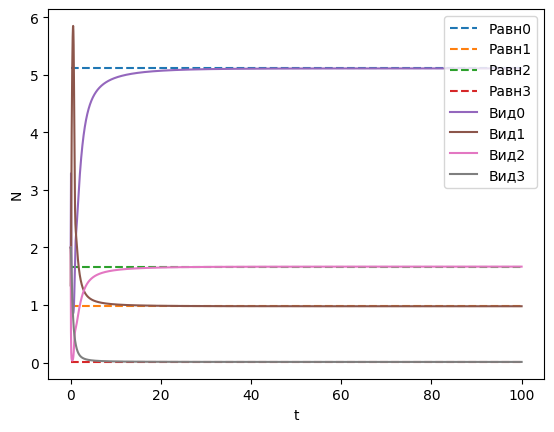

In [15]:
slc_start = 0
slc = -1

start = 0
leg = []

for i in range(start,n):
    plt.plot([0, Tl[slc-1]], [NF[i]]*2, "--")
    leg.append(f"Равн{i}")

for i in range(start,n):
    plt.plot(Tl[slc_start:slc], Nl[slc_start:slc,i])
    leg.append(f"Вид{i}")

plt.legend(
    leg, 
    loc='upper right'
)
plt.xlabel('t')
plt.ylabel('N')
print(NF)

print(Nl[-1])

plt.savefig("./figs/exp1.pdf")

In [ ]:
# cycle chain
def right_cycle(t, x):
    return np.append(
        [ Q - alpha[0] * x[0] * x[1] + sum(a * m * x) ],
        [
            x[i] * (-m[i] + k[i] * alpha[i-1] * x[i-1] - (alpha[i] * x[i+1] if i < n-1 else 0 ))
            for i in range(1, n)
        ]
    )

In [164]:
t_s2 = np.arange(0, 50, 0.01)
N1 = np.array([ 5 ] * n)

Tl2, Nl2 = runge_kutta(right_cycle, N1, t_s2)

[55.532926    6.25        2.91496945  0.        ]


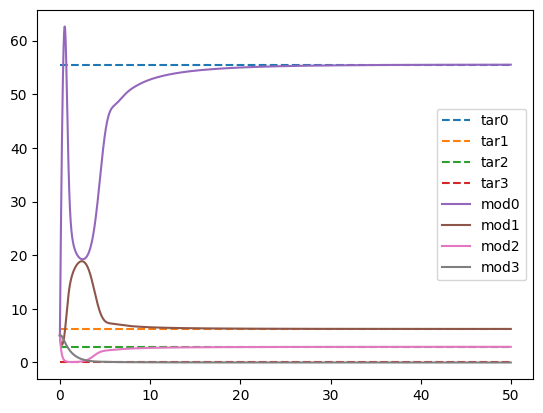

In [165]:
slc = -1

start = 0
leg = []

for i in range(start,n):
    plt.plot([0, Tl2[slc-1]], [NC[i]]*2, "--")
    leg.append(f"tar{i}")

for i in range(start,n):
    plt.plot(Tl2[:slc], Nl2[:slc,i])
    leg.append(f"mod{i}")

plt.legend(leg)
print(NC)

In [166]:
print(NF, NC)

[53.33333333  6.25        2.75        0.        ] [55.532926    6.25        2.91496945  0.        ]


In [ ]:
def get_right_split2(func_v, func_1=None):
    func_1 = func_1 or func_v
    def right(t, x):
        return np.append(
            [Q - alpha[0] * func_1(x[0]) * x[1]],
            [
                -m[i] * x[i] + k[i] * alpha[i-1] * func_v(x[i-1]) * x[i] - (x[i+1] if i < n-1 else 0 ) * alpha[i] * func_v(x[i])
                for i in range(1, n)
            ]
        )
    return right
